# 2D Rectangular Shape Morphing

## Generating random polygons

[[-0.56469477 -0.3029628 ]
 [-0.60884456 -0.5386239 ]
 [ 0.2261476  -0.30257256]
 [-0.2733545   0.62820018]
 [-0.49672529  0.08053127]
 [-0.96676875  0.26851567]
 [-0.56469477 -0.3029628 ]]


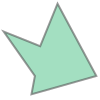

In [2]:
import numpy as np
import random
from shapely.geometry import Polygon

def generate_random_polygon():

    # Random number of points between 3 and 10
    num_points = random.randint(3, 10)

    # Generate random points within the range of -1 and 1 for x and y coordinates
    points = np.random.uniform(-1, 1, (num_points, 2))

    # Sort points in counterclockwise order to create a closed polygon
    centroid = np.mean(points, axis=0)
    points = sorted(points, key=lambda p: np.arctan2(p[1] - centroid[1], p[0] - centroid[0]))

    # Close the polygon by repeating the first point
    points.append(points[0])

    return np.array(points)

polygon_points = generate_random_polygon()
print(polygon_points)

polygon = Polygon(polygon_points)
polygon

In [23]:
import numpy as np
import random
import shapely.geometry as geom
import shapely.ops as ops
import shapely.affinity as aff

def generate_random_rectangle():
    while True:
        # Generate random x and y bounds
        x1, x2 = sorted(np.random.uniform(-1, 1, 2))
        y1, y2 = sorted(np.random.uniform(-1, 1, 2))

        # Calculate width and height
        width = abs(x2 - x1)
        height = abs(y2 - y1)

        # Ensure the ratio does not exceed 2:1
        if 0.5 <= width / height <= 2.0:
            return geom.box(x1, y1, x2, y2)

def generate_random_axis_aligned_polygon():
    # Random number of rectangles between 4 and 5
    num_rectangles = random.randint(2, 3)

    union_polygon = geom.MultiPolygon()
    while isinstance(union_polygon, geom.MultiPolygon):

        # Generate random rectangles with axis-aligned boundaries
        rectangles = []
        centroids = []
        for _ in range(num_rectangles):
            rect = generate_random_rectangle()
            shift = np.random.uniform(-1, 1, 2)
            rect = aff.translate(rect, xoff=shift[0], yoff=shift[1])
            rectangles.append(rect)

        # Compute the union of all rectangles to create a polygon
        union_polygon = ops.unary_union(rectangles)

    # Center the union around (0, 0)
    minx, miny, maxx, maxy = union_polygon.bounds
    centroid = union_polygon.centroid
    union_polygon = aff.translate(union_polygon, xoff=-centroid.x, yoff=-centroid.y)

    # Scale to fit within (-1, 1) in both x and y directions, preserving aspect ratio
    scale_factor = 1 / min(maxx - minx, maxy - miny)
    union_polygon = aff.scale(union_polygon, xfact=scale_factor, yfact=scale_factor, origin=(0, 0))

    exterior_coords = list(union_polygon.exterior.coords)
    return Polygon(np.array(exterior_coords))

N = 7
polygons = [generate_random_axis_aligned_polygon() for i in range(N**2)]

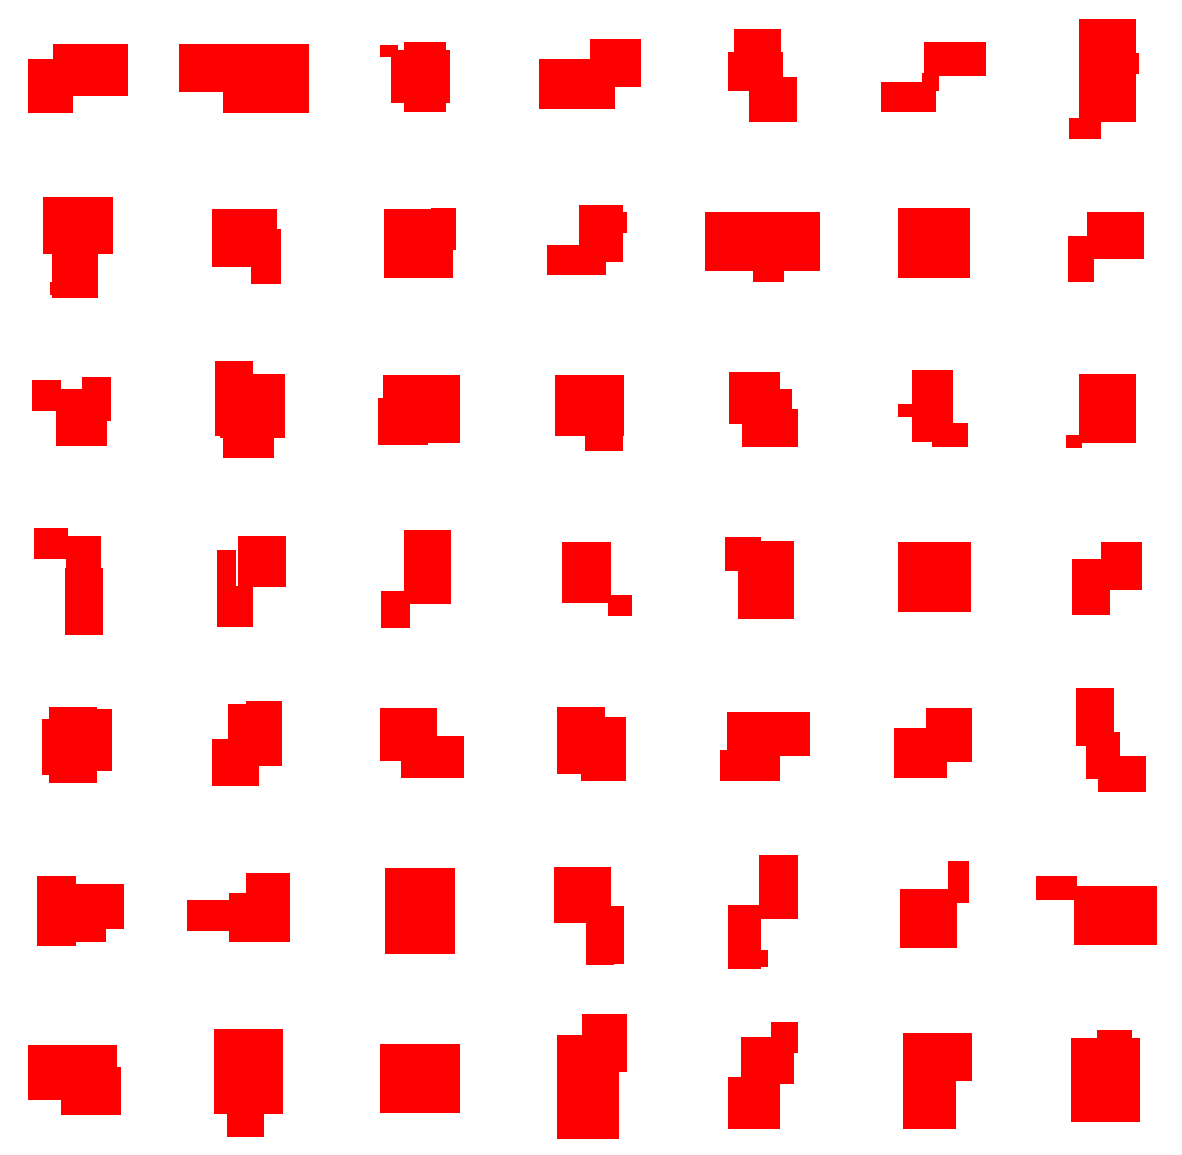

In [24]:
import matplotlib.pyplot as plt
from plot import plot_polygon

# Set up a figure
fs = 3
fig, axs = plt.subplots(N, N, figsize=(fs*N, fs*N))
fig.set_facecolor('white')
axs = axs.flatten()

for ax, poly in zip(axs, polygons):

    # Set axes
    ax.set_facecolor('white')
    _ = [ax.axis('off'), ax.axes.set_aspect('equal')]
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])

    # Plot polygon
    plot_polygon(ax, poly, fc="red", ec="black", lw=0, alpha=1)

## Graph from polygon

In [25]:
import networkx as nx

def graph_from_polygon(polygon):

    # Set up graph
    G = nx.Graph()
    exterior_coords = list(polygon.exterior.coords)
    num_points = len(exterior_coords)

    # Add nodes for each point
    for i, (x, y) in enumerate(exterior_coords):
        G.add_node(i, pos=(x, y))

    # Add edges between consecutive points to form the polygon
    for i in range(num_points - 1):
        G.add_edge(i, (i + 1) % num_points)

    return G

graphs = [graph_from_polygon(poly) for poly in polygons]

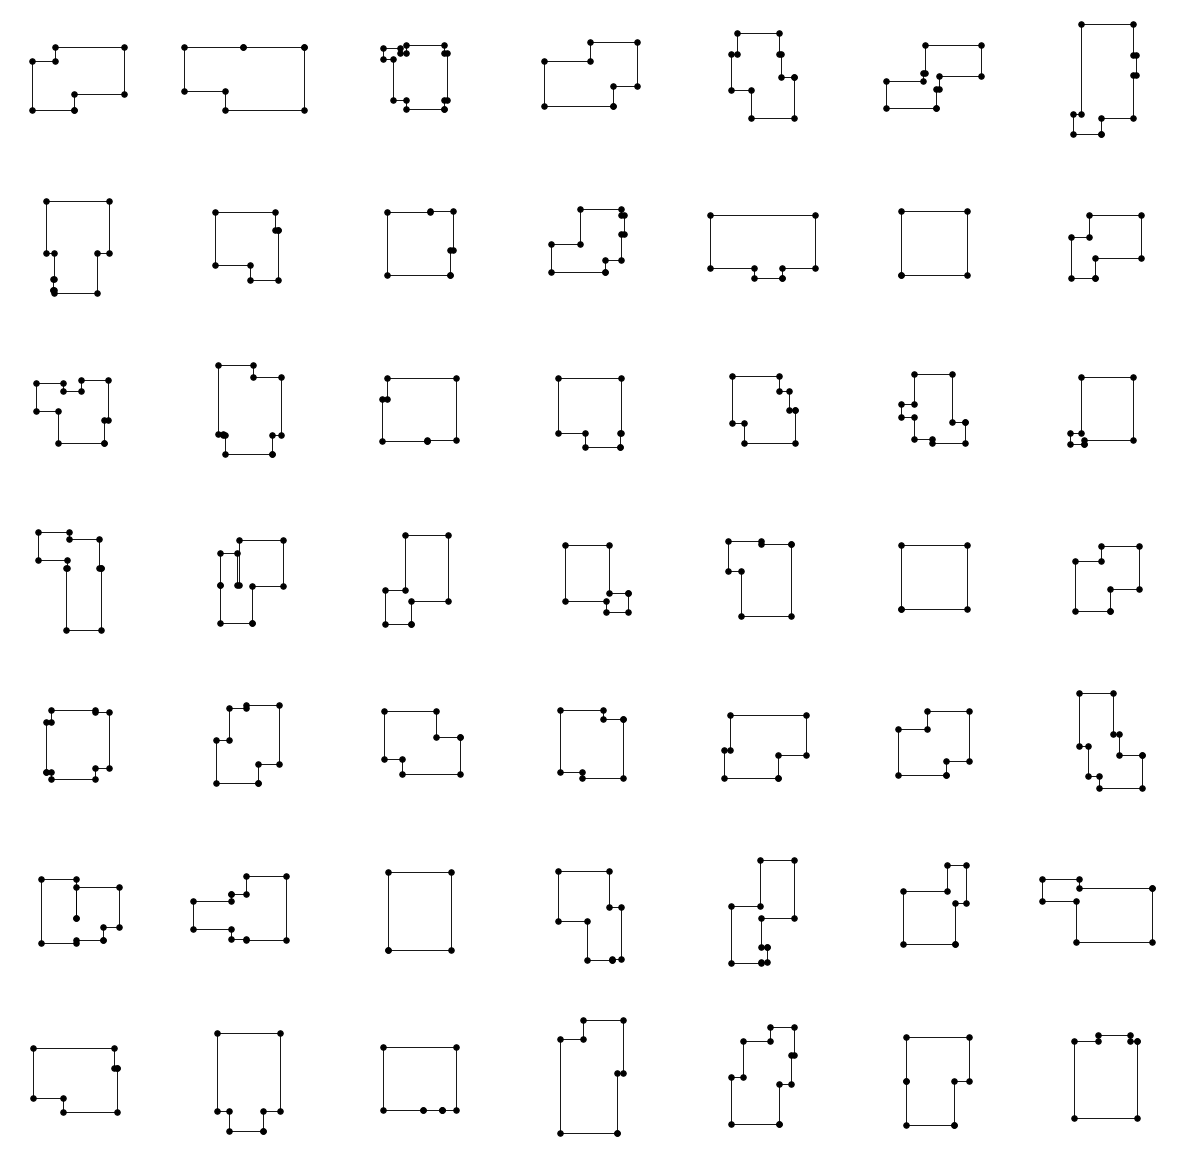

In [27]:
# Set up a figure
fs = 3
fig, axs = plt.subplots(N, N, figsize=(fs*N, fs*N))
fig.set_facecolor('white')
axs = axs.flatten()

# Graph settings
node_size = fs * 10
edge_size = fs * 0.3

for ax, G in zip(axs, graphs):

    # Set axes
    ax.set_facecolor('white')
    _ = [ax.axis('off'), ax.axes.set_aspect('equal')]
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    # Extract positions of graph
    pos = {n: np.array(G.nodes[n]['pos']) for n in G.nodes}

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='black', ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color='black', width=edge_size, ax=ax)